# Forecasting with delayed historical data

In the world of forecasting, accurate predictions depend on historical data. In many real-world scenarios, however, the available data is often subject to delays.  Consider the retail industry, where sales data often arrive with delays ranging from a few days to several weeks. Such delays pose significant challenges for autoregressive models, which use past values of the target variable to predict future values.

One of the primary obstacles when working with delayed data is accurately evaluating model performance. Incorporating the delay into the evaluation becomes critical, as models must be evaluated based on the data available at the time of prediction. Failure to do so can lead to overly optimistic results, as the model may be accessing data that wasn't available during the prediction window.

One way to mitigate this challenge is to include lags that are greater than the maximum delay that the historical data can have. For example, if the data is delayed by 7 days, the minimum lag should be 7 days. This ensures that the model has access to the data it needs to make predictions. However, this approach will not always produce valid results because the available data may be too far in the past to be useful for prediction.

<p style="text-align: center">
<img src="../img/predict_extended_lags_periods.gif" style="width: 650px;">
<br>
<font size="2.5"> <i>Predictions with lags (last window available) greater than the maximum delay.</i></font>

## Libraries

In [9]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Data

In [10]:
# Download data and preprocessing
# ==============================================================================
data = fetch_dataset(name='h2o', raw=True, verbose=False,
                     kwargs_read_csv={'header': 0, 'names': ['y', 'datetime']})

data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

data.head(3)

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


Train dates      : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Validation dates : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


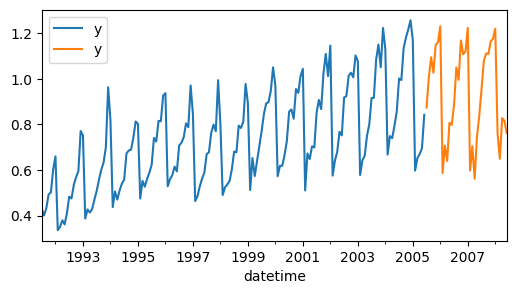

In [11]:
# Train-validation dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'
data_train = data[:end_train].copy()
data_test  = data[end_train:].copy()

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

## Forecasting with delayed data

The data set used in this example is a time series of monthly values. Let's assume that the data is delayed by 3 months. This means that the data for January will not be available until April, the data for February will not be available until May, and so on. Because the data is delayed by 3 months, it is not possible to use lags 1, 2, or 3 to predict the target variable because these data are not available at the time of the prediction. Instead, the minimum lag must be 4.

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123),
                 lags      = range(4, 12) 
             )

forecaster.fit(y=data_train['y'])

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To a better understanding of backtesting process visit the <a href="https://skforecast.org/latest/user_guides/backtesting">Backtesting user guide</a>

</div>

In [13]:
# Backtesting forecaster
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          steps                 = 6,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data_train),
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

print(f"Backtest error: {metric}")

  0%|          | 0/6 [00:00<?, ?it/s]

Backtest error: 0.1203853105639822


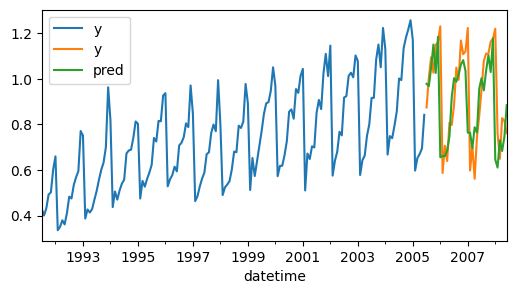

In [14]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## Forecasting in production

Once the model has been evaluated and validated, including the delay, it can be used to make predictions in production. In this case, the model will use the data available at the time of prediction, which will be the data from 3 months ago. The way the model identiy the data to use is by positional index. For example, the lag 4 will use the value that is in the position 4 strarting from the end of the last available window, assuming that the last window ends just before the first forecast date.

Because of the delay, the most recent data available will not be the most recent data in the time series. To ensure that the lags are taken from the correct position, the last window must be extended with dummy values. The number of dummy values must be equal to the number of steps between the last available data and the date just before the first prediction date. In this case, the delay is 3 months, so the number of dummy values must be 3.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

Learn how to use <a href="https://skforecast.org/latest/user_guides/forecaster-in-production">forecaster models in production</a>.

</div>